# Spatially varying damping

**Author**: Weiwei Wang, Max Albert

**Date**: Dec 2012 (updated Jan 2014)

**Purpose**: Illustrate how to use spatially varying damping in Finmag. This example also shows how to use the `TimeZeeman` class to apply a time-varying external field.

The simulation system is a Permalloy bar with dimensions $200 \times 20 \times 10 \mathrm{nm}^3$. 
We create the mesh using the dolfin class `BoxMesh` with discretization sizes $5 \times 5 \times 10 \mathrm{nm}^3$ for each cuboid (a cuboid is made up of six tetrahedra), i.e. we need $40 \times 4 \times 1$ subdivisions.

In [1]:
import dolfin as df
import numpy as np
mesh = df.BoxMesh(0, 0, 0, 200, 20, 10, 40, 4, 1)

We create a simulation object with this mesh including the exchange and anisotropy interactions.

In [2]:
from finmag import Simulation as Sim
from finmag.energies import Exchange
from finmag.energies import UniaxialAnisotropy

sim = Sim(mesh, 8.6e5, unit_length=1e-9)
sim.set_m((1, 0, 0))

exchange = Exchange(13.0e-12)
sim.add(exchange)
    
anis = UniaxialAnisotropy(K1=1e5, axis=[1, 0, 0])
sim.add(anis)

[2014-09-12 15:27:50] INFO: Finmag logging output will be appended to file: '/home/mb4e10/.finmag/global.log'
[2014-09-12 15:27:50] DEBUG: Building modules in 'native'...
[2014-09-12 15:27:51] DEBUG: FinMag          5449:331cc720ef8a517ed1c48eb6beccd246e9e63344
[2014-09-12 15:27:51] DEBUG: Dolfin          1.4.0                Matplotlib      1.3.1               
[2014-09-12 15:27:51] DEBUG: Numpy           1.8.1                Scipy           0.14.0              
[2014-09-12 15:27:51] DEBUG: IPython         2.1.0                Python          2.7.6               
[2014-09-12 15:27:51] DEBUG: Paraview        4.0.1-1ubuntu1       Sundials        2.5.0               
[2014-09-12 15:27:51] DEBUG: Boost-Python    <unknown>            Linux           Ubuntu 14.04.1 LTS  
[2014-09-12 15:27:51] DEBUG: Registering debug signal handler. Press Ctrl-Z at any time to stop execution and jump into the debugger.
[2014-09-12 15:27:51] INFO: Finmag logging output will be written to file: '/home/mb4e10/

Suppose the damping varies linearly from left end ($\alpha=0.01$) to the right end ($\alpha=2.01$). To define this in Finmag, we need to assign a value to `sim.alpha` which represents such a spatially varying function. One option would be to use a `dolfin.Expression` (as in the commented line below), but we can also assign it a Python function directly. This is the option we choose here.

In [3]:
## Define spatially varying damping

#
# First option: using a dolfin.Expression
#
#sim.alpha = df.Expression("0.01 * (1 + x[0])")

#
# Second option: using a Python function which returns
# the damping value at a given point.
#
def damping(pt):
    return 0.01 * (1 + pt[0])

sim.alpha = damping

We expose the bar in a microwave environment, where an external field of strength $h=h_0 \sin(\omega t)$ is applied in $y$ direction. To define this in Finmag we use the `TimeZeeman` class, which represents a field that varies in time but is constant in space for each fixed  point in time.

In [4]:
from finmag.energies import TimeZeeman
GHz = 1e9
omega = 10 * 2 * np.pi * GHz
H = df.Expression(("0.0", "H0*sin(omega*t)", "0.0"), H0=1e3,omega=omega, t=0.0)
H_app = TimeZeeman(H)

def update_H_ext(t):
    H_app.update(t)

sim.add(H_app, with_time_update=update_H_ext)

[2014-09-12 15:28:02] DEBUG: Adding interaction TimeZeeman to simulation.


Now we simulate the system for 1 ns.

In [5]:
sim.run_until(1e-9)

[2014-09-12 15:28:04] INFO: Create integrator sundials with kwargs={}
[2014-09-12 15:28:04] DEBUG: Creating integrator with backend sundials.
[2014-09-12 15:28:04] DEBUG: Updating get method for steps in TableWriter(name=unnamed.ndt)
[2014-09-12 15:28:04] DEBUG: Updating get method for last_step_dt in TableWriter(name=unnamed.ndt)
[2014-09-12 15:28:04] DEBUG: Updating get method for dmdt in TableWriter(name=unnamed.ndt)
[2014-09-12 15:28:04] INFO: Simulation will run until t = 1e-09 s.
[2014-09-12 15:28:09] INFO: Simulation has reached time t = 1e-09 s.


Next we probe the spatial magnetisation through the middle line of the bar ($y=10$ nm, $z=5$nm).

In [6]:
xs = np.linspace(0, 200, 200)
m_vals = sim.probe_field('m', [[x, 10, 5] for x in xs])
mx = m_vals[:, 0]
my = m_vals[:, 1]
mz = m_vals[:, 2]
ma = np.sqrt(my * my + mz * mz)

Finally we plot the result. It can clearly be seen that due to the spatially varying damping the final magnetisation is non-uniform along the x-axis.

/usr/lib/pymodules/python2.7/matplotlib/figure.py:1595: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


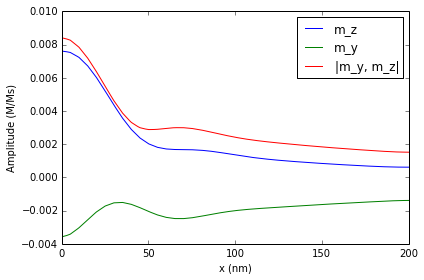

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(xs, mz, label='m_z')
plt.plot(xs, my, label='m_y')
plt.plot(xs, ma, label='|m_y, m_z|')
plt.legend()
plt.xlabel('x (nm)')
plt.ylabel('Amplitude (M/Ms)')